In [1]:
import pandas as pd
import re
import contractions
import nltk
import spacy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gensim
import tensorflow
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from langdetect import detect
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud



In [2]:
dataset = pd.read_csv(r'C:\Users\MSI GF63\Documents\UiTM Stuff\Final Year Project\Datasets\fake new dataset.csv')
dataset = pd.DataFrame(dataset)
dataset.head()

,Unnamed: 0,title,text,subcategory,label
0,0,FACEBOOK DELETES MICHIGAN ANTI-LOCKDOWN GROUP ...,Facebook has shuttered a popular group for Mic...,false news,0
1,1,Other Viewpoints: COVID-19 is worse than the flu,We can now officially put to rest all comparis...,true,1
2,2,Bermuda's COVID-19 cases surpass 100,The Ministry of Health in Bermuda has confirme...,true,1
3,3,Purdue University says students face 'close to...,"Purdue University President Mitch Daniels, the...",partially false,0
4,4,THE HIGH COST OF LOCKING DOWN AMERICA: “WE’VE ...,Locking down much of the country may have help...,false news,0


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3119 entries, 0 to 3118
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   3119 non-null   int64 
 1   title        3118 non-null   object
 2   text         3118 non-null   object
 3   subcategory  3119 non-null   object
 4   label        3119 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 122.0+ KB


In [4]:
# Function to detect language
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = 'Unknown'
    return lang

# Apply language detection to the entire dataset
language_set = set()
for text in dataset['text']:
    lang = detect_language(text)
    language_set.add(lang)

# Print the detected languages
print("Languages detected in the dataset:", language_set)

Languages detected in the dataset: {'en', 'Unknown'}


In [3]:
dataset.drop(["title"], axis=1, inplace=True)
dataset.drop(["subcategory"], axis=1, inplace=True)
dataset.head()

,Unnamed: 0,text,label
0,0,Facebook has shuttered a popular group for Mic...,0
1,1,We can now officially put to rest all comparis...,1
2,2,The Ministry of Health in Bermuda has confirme...,1
3,3,"Purdue University President Mitch Daniels, the...",0
4,4,Locking down much of the country may have help...,0


In [4]:
#Replace missing value and convert to lowercase for consistency
nan_mask = dataset['text'].isna()
dataset.loc[nan_mask, 'text'] = ''
dataset['text'] = dataset['text'].apply(lambda x: x.lower())
dataset.head()

,Unnamed: 0,text,label
0,0,facebook has shuttered a popular group for mic...,0
1,1,we can now officially put to rest all comparis...,1
2,2,the ministry of health in bermuda has confirme...,1
3,3,"purdue university president mitch daniels, the...",0
4,4,locking down much of the country may have help...,0


In [5]:
#Remove contractions process
def remove_contractions(text):
    if type(text) == str:
        return contractions.fix(text)
    else:
        return text

dataset['text'] = dataset['text'].apply(remove_contractions)
dataset.head()

,Unnamed: 0,text,label
0,0,facebook has shuttered a popular group for mic...,0
1,1,we can now officially put to rest all comparis...,1
2,2,the ministry of health in bermuda has confirme...,1
3,3,"purdue university president mitch daniels, the...",0
4,4,locking down much of the country may have help...,0


In [6]:
#Tokenization process
dataset['text'] = dataset['text'].astype(str)  #Treat text columns as string regarding the original data type
tokenizer = RegexpTokenizer(r'\w+')
dataset['tokens'] = dataset['text'].apply(lambda x: tokenizer.tokenize(x))
print(dataset['tokens'])

0       [facebook, has, shuttered, a, popular, group, ...
1       [we, can, now, officially, put, to, rest, all,...
2       [the, ministry, of, health, in, bermuda, has, ...
3       [purdue, university, president, mitch, daniels...
4       [locking, down, much, of, the, country, may, h...
                              ...                        
3114    [quarantine, advised, for, 80, persons, across...
3115    [south, sudan, has, begun, screening, all, tra...
3116    [coronavirus, 2019, ncov, is, a, new, respirat...
3117    [characterizing, patients, hospitalized, with,...
3118    [just, something, to, be, prepared, for, but, ...
Name: tokens, Length: 3119, dtype: object


In [7]:
#Remove stopword
def stopword_text(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    return filtered_tokens

dataset['removed_stopword'] = dataset['tokens'].apply(stopword_text)

print(dataset['removed_stopword'])

0       [facebook, shuttered, popular, group, michigan...
1       [officially, put, rest, comparisons, covid, 19...
2       [ministry, health, bermuda, confirmed, newspap...
3       [purdue, university, president, mitch, daniels...
4       [locking, much, country, may, helped, flatten,...
                              ...                        
3114    [quarantine, advised, 80, persons, across, sta...
3115    [south, sudan, begun, screening, travelers, ai...
3116    [coronavirus, 2019, ncov, new, respiratory, il...
3117    [characterizing, patients, hospitalized, covid...
3118    [something, prepared, bad, thing, consider, nu...
Name: removed_stopword, Length: 3119, dtype: object


In [8]:
dataset['removed_stopword'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3119 entries, 0 to 3118
Series name: removed_stopword
Non-Null Count  Dtype 
--------------  ----- 
3119 non-null   object
dtypes: object(1)
memory usage: 24.5+ KB


In [8]:
removed_stopword = pd.DataFrame(dataset['removed_stopword'])

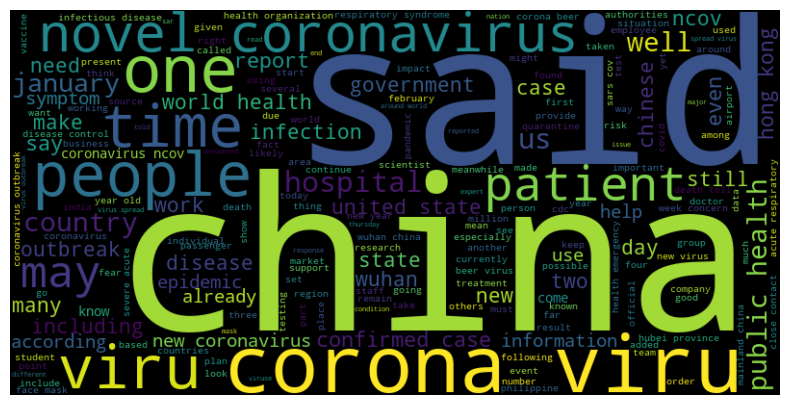

In [9]:
#Wordcloud
# Join the tokenized words into a single string
text = dataset['removed_stopword'].apply(lambda x: " ".join(x))

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400).generate(" ".join(text))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
#Stemming process
stemmer = PorterStemmer()

def stem(tokens):
    return[stemmer.stem(token) for token in tokens]

dataset['stem'] = dataset['removed_stopword'].apply(lambda x: stem(word_tokenize(str(x))))
dataset['stem'] = dataset['stem'].apply(lambda tokens: ' '.join(tokens))


print(dataset['stem'])

0       [ 'facebook ' , 'shutter ' , 'popular ' , 'gro...
1       [ 'offici ' , 'put ' , 'rest ' , 'comparison '...
2       [ 'ministri ' , 'health ' , 'bermuda ' , 'conf...
3       [ 'purdu ' , 'univers ' , 'presid ' , 'mitch '...
4       [ 'lock ' , 'much ' , 'countri ' , 'may ' , 'h...
                              ...                        
3114    [ 'quarantin ' , 'advis ' , '80 ' , 'person ' ...
3115    [ 'south ' , 'sudan ' , 'begun ' , 'screen ' ,...
3116    [ 'coronaviru ' , '2019 ' , 'ncov ' , 'new ' ,...
3117    [ 'character ' , 'patient ' , 'hospit ' , 'cov...
3118    [ 'someth ' , 'prepar ' , 'bad ' , 'thing ' , ...
Name: stem, Length: 3119, dtype: object


In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each list of tokens
sentiment_scores = dataset['removed_stopword'].apply(lambda tokens: sid.polarity_scores(' '.join(tokens)))
dataset['sentiment_scores'] = sentiment_scores

def classify_sentiment(compound_scores):
    if compound_scores > 0:
        return 'Positive'
    elif compound_scores < 0:
        return 'Negative'
    
    
dataset['sentiment'] = dataset['sentiment_scores'].apply(lambda scores: classify_sentiment(scores['compound']))

print(dataset[['removed_stopword', 'sentiment']].head(10))

                                    removed_stopword sentiment
0  [facebook, shuttered, popular, group, michigan...  Negative
1  [officially, put, rest, comparisons, covid, 19...  Negative
2  [ministry, health, bermuda, confirmed, newspap...  Negative
3  [purdue, university, president, mitch, daniels...  Negative
4  [locking, much, country, may, helped, flatten,...  Negative
5  [new, york, times, published, article, popular...  Positive
6  [delhi, eight, nurses, test, positive, covid, ...  Positive
7  [coronavirus, outbreak, began, centers, diseas...  Negative
8  [pearl, river, county, man, recovering, home, ...  Positive
9  [general, view, campus, purdue, university, oc...  Negative


In [10]:
sentiment_counts = dataset['sentiment'].value_counts()
sentiment_percentages = (sentiment_counts / len(dataset)) * 100

print("Sentiment Analysis Statistics:")
print("-----------------------------")
print("Sentiment Counts:")
print(sentiment_counts)
print("\nSentiment Percentages:")
print(sentiment_percentages)

Sentiment Analysis Statistics:
-----------------------------
Sentiment Counts:
sentiment
Negative    1628
Positive    1480
Name: count, dtype: int64

Sentiment Percentages:
sentiment
Negative    52.196217
Positive    47.451106
Name: count, dtype: float64


In [11]:
sentiment_counts_frame = pd.DataFrame(sentiment_counts)
print(sentiment_counts_frame)

           count
sentiment       
Negative    1628
Positive    1480


In [12]:
#Initial bow and tfidf 
X = dataset['stem']
y = dataset['label']

#BOW
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(X) 

#Tfidf
tfidf_vectorizer = TfidfVectorizer()

X_tfidf = tfidf_vectorizer.fit_transform(X) 


In [16]:
print(X_bow)

  (0, 9283)	4
  (0, 22263)	1
  (0, 19238)	1
  (0, 10950)	9
  (0, 15932)	3
  (0, 17841)	1
  (0, 10791)	4
  (0, 9249)	1
  (0, 14806)	5
  (0, 15678)	1
  (0, 10113)	1
  (0, 7324)	1
  (0, 10031)	1
  (0, 22894)	1
  (0, 6651)	1
  (0, 6895)	1
  (0, 9136)	2
  (0, 19982)	2
  (0, 1022)	1
  (0, 1)	1
  (0, 15777)	3
  (0, 15697)	2
  (0, 20646)	2
  (0, 7570)	2
  (0, 17780)	1
  :	:
  (3118, 23308)	1
  (3118, 9924)	1
  (3118, 6258)	1
  (3118, 23955)	1
  (3118, 18882)	1
  (3118, 12001)	1
  (3118, 23278)	1
  (3118, 26691)	1
  (3118, 8717)	3
  (3118, 23679)	1
  (3118, 8494)	1
  (3118, 18106)	1
  (3118, 25272)	1
  (3118, 5335)	1
  (3118, 11910)	1
  (3118, 10047)	1
  (3118, 3781)	1
  (3118, 25361)	1
  (3118, 26982)	1
  (3118, 20048)	1
  (3118, 7653)	2
  (3118, 16001)	1
  (3118, 25171)	1
  (3118, 25152)	1
  (3118, 13238)	1


In [17]:
print(X_tfidf)

  (0, 20545)	0.028630397128053153
  (0, 18923)	0.05157619030706155
  (0, 16026)	0.027961708874558747
  (0, 1228)	0.035418644085457085
  (0, 14201)	0.053685848118574755
  (0, 26141)	0.03221238551801116
  (0, 19881)	0.029344973105228333
  (0, 19055)	0.04210103713254722
  (0, 223)	0.03450306458886742
  (0, 7250)	0.03575530295805815
  (0, 20489)	0.03394518055140229
  (0, 25454)	0.03181424221135406
  (0, 445)	0.06140741662783676
  (0, 6791)	0.06658977176705394
  (0, 11332)	0.04845005625832674
  (0, 16125)	0.05106795218845074
  (0, 22980)	0.017128962990011674
  (0, 23252)	0.03148108073652586
  (0, 5686)	0.07556179346143208
  (0, 9295)	0.03240352510267146
  (0, 26577)	0.02258669901641021
  (0, 26613)	0.022426847054580843
  (0, 2852)	0.027232233851570177
  (0, 10537)	0.05347540025202845
  (0, 23963)	0.04939157031418263
  :	:
  (3118, 6467)	0.0518538441137976
  (3118, 26829)	0.033830426164542134
  (3118, 9337)	0.06666178633828805
  (3118, 23801)	0.03584987139365141
  (3118, 19149)	0.04960859470

In [13]:
#Split data for bow
X_bow_train, X_bow_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

#Split data for tfidf
X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [14]:
total_dataset = len(dataset)
total_train = X_tfidf_train.shape[0]
total_test = X_tfidf_test.shape[0]
df_totaldataset = pd.DataFrame({'Total datasets': [total_dataset]})
df_totaltrain = pd.DataFrame({'Total training datasets': [total_train]})
df_totaltest = pd.DataFrame({'Total testing datasets': [total_test]})




In [15]:
#Test with svm
from sklearn.svm import SVC
svm = SVC()

#Test with bow
svm.fit(X_bow_train, y_train)
y_pred1 = svm.predict(X_bow_test)

#Calculate accuracy
accuracy1 = accuracy_score(y_test, y_pred1)
print("Accuracy:", accuracy1)

Accuracy: 0.7884615384615384


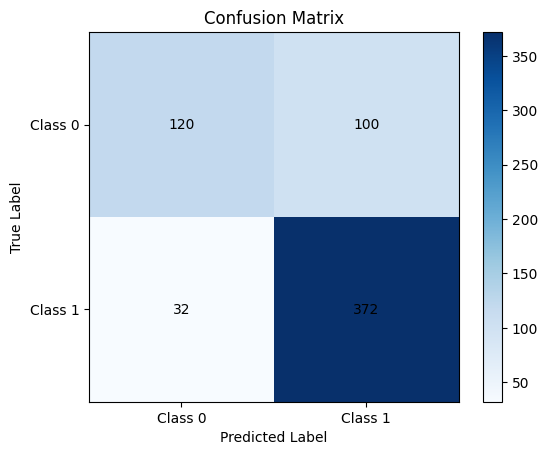

In [16]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred1)

# Visualize the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add label values to each cell in the confusion matrix
thresh = cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()


In [17]:
# Calculate accuracy
accuracy_bow_svm = accuracy1

# Calculate precision
precision_bow_svm = precision_score(y_test, y_pred1)

# Calculate recall
recall_bow_svm = recall_score(y_test, y_pred1)

# Calculate F1 score
f1_bow_svm = f1_score(y_test, y_pred1)

# Display the metrics
print("Accuracy:", accuracy_bow_svm)
print("Precision:", precision_bow_svm)
print("Recall:", recall_bow_svm)
print("F1 Score:", f1_bow_svm)

Accuracy: 0.7884615384615384
Precision: 0.788135593220339
Recall: 0.9207920792079208
F1 Score: 0.8493150684931506


In [18]:
# Create a dictionary to store the metrics
metrics_dict = {
    'Accuracy bow nb': [accuracy_bow_svm],
    'Precision bow nb': [precision_bow_svm],
    'Recall bow nb': [recall_bow_svm],
    'F1 Score bow nb': [f1_bow_svm]
}

# Convert the dictionary to a pandas DataFrame
bow_svm_df = pd.DataFrame(metrics_dict)

print(bow_svm_df)

   Accuracy bow nb  Precision bow nb  Recall bow nb  F1 Score bow nb
0         0.788462          0.788136       0.920792         0.849315


In [19]:


#Test with tfidf
svm.fit(X_tfidf_train, y_train)
y_pred2 = svm.predict(X_tfidf_test)

#Calculate accuracy
accuracy2 = accuracy_score(y_test, y_pred2)
print("Accuracy:", accuracy2)

Accuracy: 0.8173076923076923


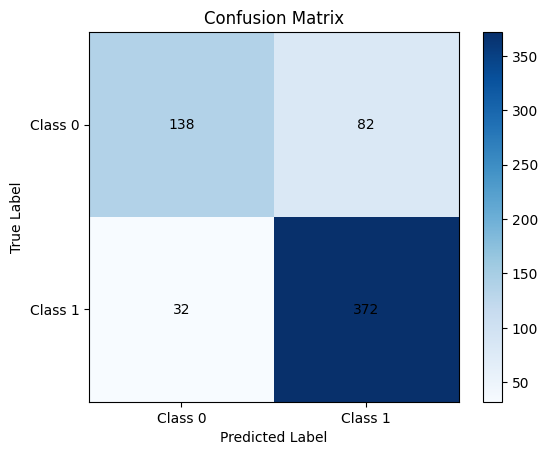

In [20]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred2)

# Visualize the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add label values to each cell in the confusion matrix
thresh = cm.max() 
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

In [21]:
# Calculate accuracy
accuracy_tfidf_svm = accuracy2

# Calculate precision
precision_tfidf_svm = precision_score(y_test, y_pred2)

# Calculate recall
recall_tfidf_svm = recall_score(y_test, y_pred2)

# Calculate F1 score
f1_tfidf_svm = f1_score(y_test, y_pred2)

# Display the metrics
print("Accuracy:", accuracy_tfidf_svm)
print("Precision:", precision_tfidf_svm)
print("Recall:", recall_tfidf_svm)
print("F1 Score:", f1_tfidf_svm)

Accuracy: 0.8173076923076923
Precision: 0.8193832599118943
Recall: 0.9207920792079208
F1 Score: 0.8671328671328672


In [22]:
# Create a dictionary to store the metrics
metrics_dict = {
    'Accuracy bow nb': [accuracy_tfidf_svm],
    'Precision bow nb': [precision_tfidf_svm],
    'Recall bow nb': [recall_tfidf_svm],
    'F1 Score bow nb': [f1_tfidf_svm]
}

# Convert the dictionary to a pandas DataFrame
tfidf_svm_df = pd.DataFrame(metrics_dict)

print(tfidf_svm_df)

   Accuracy bow nb  Precision bow nb  Recall bow nb  F1 Score bow nb
0         0.817308          0.819383       0.920792         0.867133


In [23]:
#Test with naive bayes
from sklearn.naive_bayes import MultinomialNB

# Create an instance of the Naive Bayes classifier
nb = MultinomialNB()

#Test with bow
nb.fit(X_bow_train, y_train)
y_pred3 = nb.predict(X_bow_test)

accuracy3 = accuracy_score(y_test, y_pred3)
print("Accuracy:", accuracy3)

Accuracy: 0.8012820512820513


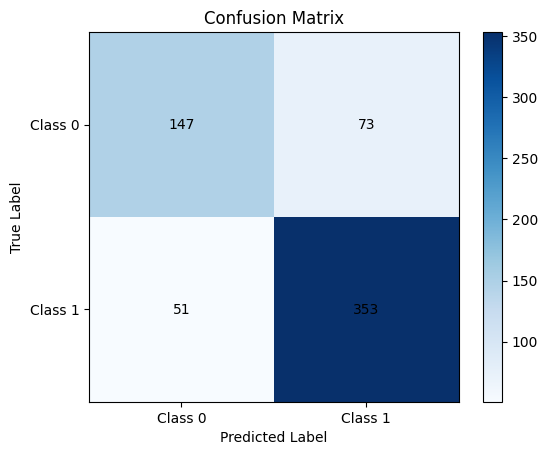

In [24]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred3)

# Visualize the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add label values to each cell in the confusion matrix
thresh = cm.max() 
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

In [25]:
# Calculate accuracy
accuracy_bow_nb = accuracy3

# Calculate precision
precision_bow_nb = precision_score(y_test, y_pred3)

# Calculate recall
recall_bow_nb = recall_score(y_test, y_pred3)

# Calculate F1 score
f1_bow_nb = f1_score(y_test, y_pred3)

# Display the metrics
print("Accuracy:", accuracy_bow_nb)
print("Precision:", precision_bow_nb)
print("Recall:", recall_bow_nb)
print("F1 Score:", f1_bow_nb)

Accuracy: 0.8012820512820513
Precision: 0.8286384976525821
Recall: 0.8737623762376238
F1 Score: 0.8506024096385543


In [26]:
# Create a dictionary to store the metrics
metrics_dict = {
    'Accuracy bow nb': [accuracy_bow_nb],
    'Precision bow nb': [precision_bow_nb],
    'Recall bow nb': [recall_bow_nb],
    'F1 Score bow nb': [f1_bow_nb]
}

# Convert the dictionary to a pandas DataFrame
bow_nb_df = pd.DataFrame(metrics_dict)

print(bow_nb_df)

   Accuracy bow nb  Precision bow nb  Recall bow nb  F1 Score bow nb
0         0.801282          0.828638       0.873762         0.850602


In [27]:
#Test with tfidf
nb.fit(X_tfidf_train, y_train)
y_pred4 = nb.predict(X_tfidf_test)

accuracy4 = accuracy_score(y_test, y_pred4)
print("Accuracy:", accuracy4)

Accuracy: 0.657051282051282


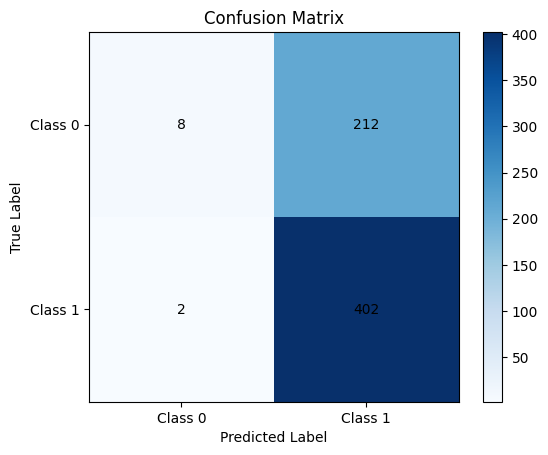

In [28]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred4)

# Visualize the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add label values to each cell in the confusion matrix
thresh = cm.max() 
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

In [29]:
# Calculate accuracy
accuracy_tfidf_nb = accuracy4

# Calculate precision
precision_tfidf_nb = precision_score(y_test, y_pred4)

# Calculate recall
recall_tfidf_nb = recall_score(y_test, y_pred4)

# Calculate F1 score
f1_tfidf_nb = f1_score(y_test, y_pred4)

# Display the metrics
print("Accuracy:", accuracy_tfidf_nb)
print("Precision:", precision_tfidf_nb)
print("Recall:", recall_tfidf_nb)
print("F1 Score:", f1_tfidf_nb)

Accuracy: 0.657051282051282
Precision: 0.6547231270358306
Recall: 0.995049504950495
F1 Score: 0.7897838899803535


In [30]:
# Create a dictionary to store the metrics
metrics_dict = {
    'Accuracy tfidf nb': [accuracy_tfidf_nb],
    'Precision tfidf nb': [precision_tfidf_nb],
    'Recall tfidf nb': [recall_tfidf_nb],
    'F1 Score tfidf nb': [f1_tfidf_nb]
}

# Convert the dictionary to a pandas DataFrame
tfidf_nb_df = pd.DataFrame(metrics_dict)

print(tfidf_nb_df)

   Accuracy tfidf nb  Precision tfidf nb  Recall tfidf nb  F1 Score tfidf nb
0           0.657051            0.654723          0.99505           0.789784


In [31]:
#Test with logistic regression
from sklearn.linear_model import LogisticRegression

# Create an instance of the Logistic Regression classifier
lr = LogisticRegression(max_iter=1000)

#Test with bow
lr.fit(X_bow_train, y_train)
y_pred5 = lr.predict(X_bow_test)

accuracy5 = accuracy_score(y_test, y_pred5)
print("Accuracy:", accuracy5)



Accuracy: 0.7692307692307693


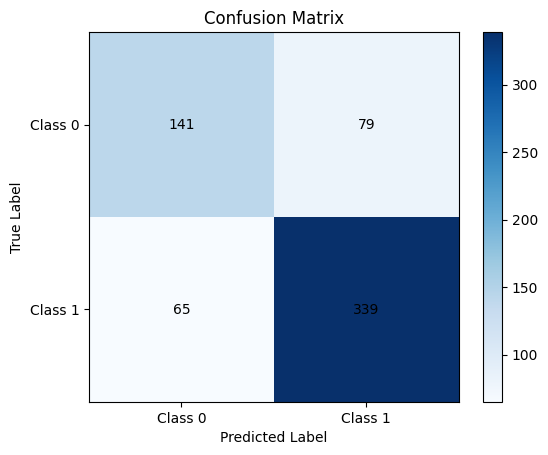

In [32]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred5)

# Visualize the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add label values to each cell in the confusion matrix
thresh = cm.max() 
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

In [33]:
# Calculate accuracy
accuracy_bow_lr = accuracy5

# Calculate precision
precision_bow_lr = precision_score(y_test, y_pred5)

# Calculate recall
recall_bow_lr = recall_score(y_test, y_pred5)

# Calculate F1 score
f1_bow_lr = f1_score(y_test, y_pred5)

# Display the metrics
print("Accuracy:", accuracy_bow_lr)
print("Precision:", precision_bow_lr)
print("Recall:", recall_bow_lr)
print("F1 Score:", f1_bow_lr)

Accuracy: 0.7692307692307693
Precision: 0.8110047846889952
Recall: 0.8391089108910891
F1 Score: 0.8248175182481751


In [34]:
# Create a dictionary to store the metrics
metrics_dict = {
    'Accuracy bow lr': [accuracy_bow_lr],
    'Precision bow lr': [precision_bow_lr],
    'Recall bow lr': [recall_bow_lr],
    'F1 Score bow lr': [f1_bow_lr]
}

# Convert the dictionary to a pandas DataFrame
bow_lr_df = pd.DataFrame(metrics_dict)

print(bow_lr_df)

   Accuracy bow lr  Precision bow lr  Recall bow lr  F1 Score bow lr
0         0.769231          0.811005       0.839109         0.824818


In [35]:
#Test with tfidf
lr.fit(X_tfidf_train, y_train)
y_pred6 = lr.predict(X_tfidf_test)

accuracy6 = accuracy_score(y_test, y_pred6)
print("Accuracy:", accuracy6)

Accuracy: 0.8028846153846154


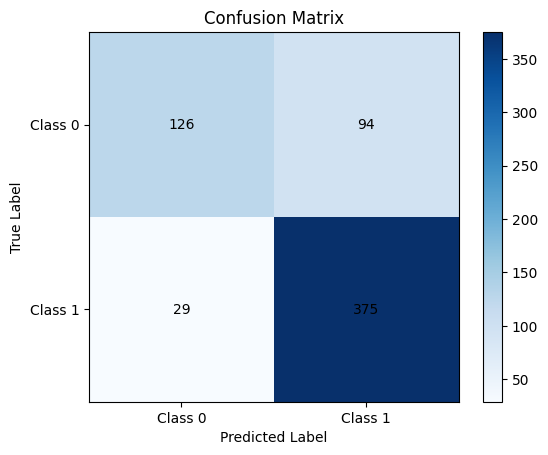

In [36]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred6)

# Visualize the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add label values to each cell in the confusion matrix
thresh = cm.max() 
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

In [37]:
# Calculate accuracy
accuracy_tfidf_lr = accuracy6

# Calculate precision
precision_tfidf_lr = precision_score(y_test, y_pred6)

# Calculate recall
recall_tfidf_lr = recall_score(y_test, y_pred6)

# Calculate F1 score
f1_tfidf_lr = f1_score(y_test, y_pred6)

# Display the metrics
print("Accuracy:", accuracy_tfidf_lr)
print("Precision:", precision_tfidf_lr)
print("Recall:", recall_tfidf_lr)
print("F1 Score:", f1_tfidf_lr)

Accuracy: 0.8028846153846154
Precision: 0.7995735607675906
Recall: 0.9282178217821783
F1 Score: 0.8591065292096219


In [43]:
# Create a dictionary to store the metrics
metrics_dict = {
    'Accuracy tfidf lr': [accuracy_tfidf_lr],
    'Precision tfidf lr': [precision_tfidf_lr],
    'Recall tfidf lr': [recall_tfidf_lr],
    'F1 Score tfidf lr': [f1_tfidf_lr]
}

# Convert the dictionary to a pandas DataFrame
tfidf_lr_df = pd.DataFrame(metrics_dict)

print(tfidf_lr_df)

   Accuracy tfidf lr  Precision tfidf lr  Recall tfidf lr  F1 Score tfidf lr
0           0.802885            0.799574         0.928218           0.859107


In [47]:
# Merge all dataframes vertically (along axis 0)
merged_df = pd.concat([bow_svm_df, tfidf_svm_df, bow_nb_df, tfidf_nb_df, bow_lr_df, tfidf_lr_df], axis=0)

tfidf_lr_df.to_excel('model_testing_8020.xlsx', index=True)

In [39]:
model_eval = pd.DataFrame()

In [40]:
model_eval.loc['Naive Bayes Bow','Score'] = accuracy_score(y_test, y_pred3)
model_eval.loc['Naive Bayes Tfidf','Score'] = accuracy_score(y_test, y_pred4)
model_eval.loc['SVM Bow','Score'] = accuracy_score(y_test, y_pred1)
model_eval.loc['SVM Tfidf','Score'] = accuracy_score(y_test, y_pred2)
model_eval.loc['Logistic Regression Bow','Score'] = accuracy_score(y_test, y_pred5)
model_eval.loc['Logistic Regression','Score'] = accuracy_score(y_test, y_pred6)

In [23]:
model_eval

,Score
Naive Bayes Bow,0.812500
Naive Bayes Tfidf,0.653846
SVM Bow,0.762821
SVM Tfidf,0.818910
Logistic Regression Bow,0.783654
Logistic Regression,0.807692


In [123]:
model_eval.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, Naive Bayes Bow to Logistic Regression
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Score   6 non-null      float64
dtypes: float64(1)
memory usage: 268.0+ bytes
